<a href="https://colab.research.google.com/github/jinweiRao/CHE1147-project/blob/master/Test_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow
from tensorflow import keras
from keras.optimizers import SGD, Adam,RMSprop
from keras.layers import Dense,Activation,Input
import numpy as np
import pandas as pd
from keras import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from keras import optimizers, regularizers
import seaborn as sns
from keras import callbacks
from scipy.stats.stats import pearsonr
import random
import matplotlib.pyplot
from sklearn.cluster import KMeans
from sklearn import tree

## Build baseline_model

In [0]:
data=pd.read_csv('plant_A.csv')

In [4]:
data1 = data.copy()
data1.Temp,data1.CaO=data1.Temp/1000,data1.CaO/10
data1.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,1.649,4.00,8.63,7.8,27.5,3.38,0.91,0.45,1.473
1,4.436094,1.654,3.96,9.99,9.2,23.0,4.14,2.60,0.68,1.945
2,4.499810,1.664,4.48,8.80,11.0,20.2,3.45,1.58,0.76,2.070
3,4.140865,1.680,4.24,8.10,11.5,21.1,3.76,2.47,0.88,2.161
4,4.081441,1.671,4.88,11.73,11.8,13.3,3.26,1.48,0.78,1.976


In [0]:
def Mse(prediction,truth):
  mse = sum((prediction - truth)**2)/len(truth)
  return mse

In [0]:
data1['Basicity'] = (data['CaO'] + 0.3*data['MgO'])/data['SiO2']
data['Basicity'] = (data['CaO'] + 0.3*data['MgO'])/data['SiO2']

In [0]:
X_tree = data.loc[:,'Temp':'Basicity':9]
y_tree = data.loc[:,'lp']

In [0]:
X = data1.drop(['lp','Basicity'],axis=1).values
y = data1.lp.values
#X_train,X_test=X[:8000],X[8001:11000],X[11001:]
#y_train,y_test=y[:8000],y[8001:11000],y[11001:]

In [0]:
clf = tree.DecisionTreeRegressor(max_depth = 2, criterion = 'mse')
clf = clf.fit(X_tree,y_tree)

In [89]:
tree_result = tree.export_text(clf,feature_names = ['Temp','Basicity'])
print(tree_result)

|--- Temp <= 1653.50
|   |--- Basicity <= 3.19
|   |   |--- value: [4.26]
|   |--- Basicity >  3.19
|   |   |--- value: [4.44]
|--- Temp >  1653.50
|   |--- Temp <= 1663.50
|   |   |--- value: [4.23]
|   |--- Temp >  1663.50
|   |   |--- value: [4.12]



In [0]:
act_list = ['sigmoid','tanh','softsign']
opt_list = ['adam','RMSprop','Adadelta','SGD','Nadam']

In [0]:
def baseline_model(act,opt):
    model = Sequential()
    model.add(Dense(20, input_dim = 9, activation = act))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mse', optimizer = opt, metrics=['mse']) 
    return model

In [0]:
def generate_model():
  model_list = []
  for act in act_list:
    for opt in opt_list:
      model_list.append(baseline_model(act,opt))
  return model_list

In [0]:
modelList = generate_model()

In [0]:
T1 = data1.loc[data1['Temp']<=1.653].copy()
T2 = data1.loc[data1['Temp']>1.653].copy()
B1 = T1.loc[T1['Basicity'] <= 3.19].reset_index().drop(['index'],axis = 1)
B2 = T1.loc[T1['Basicity'] > 3.19].reset_index().drop(['index'],axis = 1)
B3 = T2.loc[T2['Basicity'] <= 3.46].reset_index().drop(['index'],axis = 1)
B4 = T2.loc[T2['Basicity'] > 3.46].reset_index().drop(['index'],axis = 1)
  

In [0]:
def cv(df,model):
  kf = KFold(n_splits = 5, random_state = 10, shuffle = False)
  splits = kf.split(df)
  mse_list = []
  r_list = []
  for train_index,test_index in splits:
    X_train = df.loc[train_index,'Temp':'V2O5'].values
    X_test = df.loc[test_index,'Temp':'V2O5'].values
    y_train = df.loc[train_index,'lp'].values
    y_test = df.loc[test_index,'lp'].values
    model.fit(X_train, y_train, epochs = 1, batch_size = 20, validation_data = (X_test,y_test))
    prediction = model.predict(X_test)
    mse = Mse(prediction,y_test)
    mse_list.append(mse)
    r = pearsonr(prediction,y_test)[0]
    r_list.append(r)
  return mse_list.mean(),r_list.mean()

In [0]:
def cvsearch(modelList,df):
  result_list = [] 
  for model in modelList:
    result = cv(df,model)
    result_list.append(result)
  return result_list

In [0]:
test = modelList[:3]

In [0]:
def allsearch():
  final_list = []
  for df in [B1,B2,B3,B4]:
    final = cvsearch(test,df)
    final_list.append(final)
  return final_list

In [181]:
v = allsearch()

Train on 1944 samples, validate on 487 samples
Epoch 1/1
1944/1944 [==============================] - 0s 179us/step - loss: 0.0809 - mean_squared_error: 0.0809 - val_loss: 0.0762 - val_mean_squared_error: 0.0762


TypeError: ignored

In [177]:
v[1][1][1].predict()

AttributeError: ignored

In [0]:
estimator = KerasRegressor(build_fn = baseline_model, epochs = 150, batch_size = 20, verbose = 0)

In [143]:
hist = modelList[1].fit(X,y,epochs = 5, batch_size = 20,validation_split = 0.3)
hist.history

Train on 9697 samples, validate on 4156 samples
Epoch 1/5
9697/9697 [==============================] - 1s 129us/step - loss: 0.0854 - mean_squared_error: 0.0854 - val_loss: 0.0880 - val_mean_squared_error: 0.0880
Epoch 2/5
9697/9697 [==============================] - 1s 136us/step - loss: 0.0849 - mean_squared_error: 0.0849 - val_loss: 0.0844 - val_mean_squared_error: 0.0844
Epoch 3/5
9697/9697 [==============================] - 1s 135us/step - loss: 0.0844 - mean_squared_error: 0.0844 - val_loss: 0.0949 - val_mean_squared_error: 0.0949
Epoch 4/5
9697/9697 [==============================] - 1s 149us/step - loss: 0.0844 - mean_squared_error: 0.0844 - val_loss: 0.0871 - val_mean_squared_error: 0.0871
Epoch 5/5
9697/9697 [==============================] - 1s 149us/step - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.0873 - val_mean_squared_error: 0.0873


{'loss': [0.0853985792427957,
  0.08491286023417072,
  0.0844269032149545,
  0.084385635331081,
  0.0839128524573658],
 'mean_squared_error': [0.0853985792427957,
  0.08491286023417072,
  0.0844269032149545,
  0.084385635331081,
  0.0839128524573658],
 'val_loss': [0.08796258933153775,
  0.08443574690375624,
  0.0949040535493208,
  0.08709859266461262,
  0.0873154128226698],
 'val_mean_squared_error': [0.08796258933153775,
  0.08443574690375624,
  0.0949040535493208,
  0.08709859266461262,
  0.0873154128226698]}

In [23]:
test = cross_val_predict(estimator, X, y, cv = 5)

TypeError: ignored

In [41]:
(sum((y - test)**2))/len(test)

0.07698262589820791

In [40]:
pearsonr(test,data['lp'])

(0.41384964402572066, 0.0)

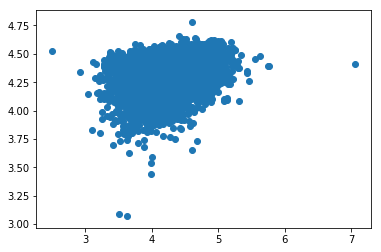

In [38]:
plt.scatter(x = data['lp'], y = test)


In [0]:
kf = KFold(n_splits = 3, random_state = 3)

In [0]:
train = kf.split(data)

In [63]:
for a,b in train:
  return data[a]

[ 2771  2772  2773 ... 13850 13851 13852] [   0    1    2 ... 2768 2769 2770]
[    0     1     2 ... 13850 13851 13852] [2771 2772 2773 ... 5539 5540 5541]
[    0     1     2 ... 13850 13851 13852] [5542 5543 5544 ... 8310 8311 8312]
[    0     1     2 ... 13850 13851 13852] [ 8313  8314  8315 ... 11080 11081 11082]
[    0     1     2 ... 11080 11081 11082] [11083 11084 11085 ... 13850 13851 13852]


In [0]:
test = np.array([1,2,3,4])

In [154]:
data.loc[a,:].values

array([[4.73619845e+00, 1.64900000e+03, 4.00000000e+01, ...,
        4.50000000e-01, 1.47300000e+00, 5.46012821e+00],
       [4.43609386e+00, 1.65400000e+03, 3.96000000e+01, ...,
        6.80000000e-01, 1.94500000e+00, 4.63010870e+00],
       [4.49980967e+00, 1.66400000e+03, 4.48000000e+01, ...,
        7.60000000e-01, 2.07000000e+00, 4.31272727e+00],
       ...,
       [4.30631481e+00, 1.65200000e+03, 3.65000000e+01, ...,
        8.80000000e-01, 2.03200000e+00, 3.50747748e+00],
       [4.29501526e+00, 1.64000000e+03, 3.30000000e+01, ...,
        8.80000000e-01, 2.04700000e+00, 3.07800000e+00],
       [4.04694232e+00, 1.68400000e+03, 4.04000000e+01, ...,
        1.16000000e+00, 2.66200000e+00, 3.11379562e+00]])